## Load things

In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import pandas as pd

import os,sys
# sys.addaudithook
rpath = os.getcwd()
sys.path.insert(0,"../")
# import utils

import dimred ### library of dimension reduction
from dimred.newpipe import Elbow
from dimred.newcistern import Knob

from dimred.data.preprocess import MinMaxScalar,AvgMaxScalar,MaxAvgScalar,scaleData
from dimred.models.linear.transform import co_kurtosis,ra_kurtosis,val_kurtosis

In [4]:
from dimred.data.loader import LoadMPI,LoadOne

In [7]:
# !ifconfig

Average Error is 567424.2727


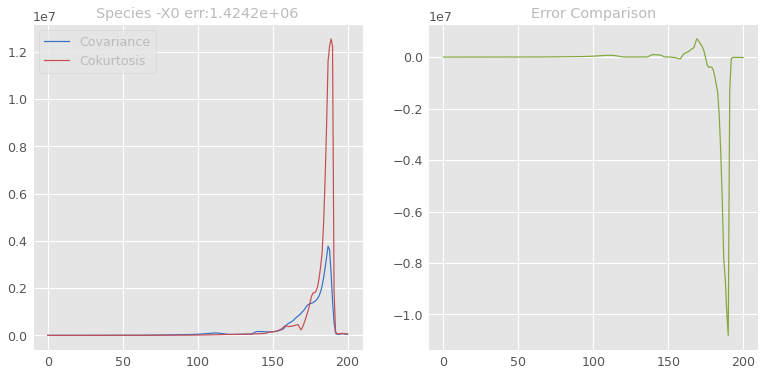

In [3]:
rn = Elbow()
rn.MyScalar = MinMaxScalar

rn.mf_build(10);
# rn.mf_alldata();
topbar = Knob(rn)


In [2]:
topbar

NameError: name 'topbar' is not defined

reading file autoignition.0.0000E+00.field.mpi...


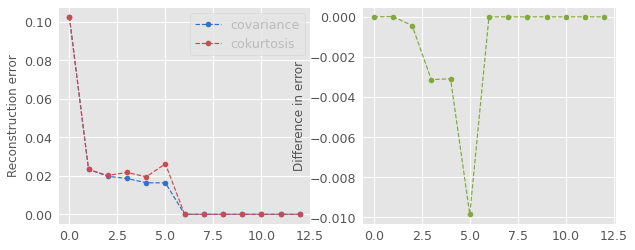

In [11]:
tn = Elbow()
tn.MyScalar = MinMaxScalar()

tn.mf_build(10);
maxbar = Knob(tn)


In [12]:
maxbar

In [15]:
rn.loader.varid

{'H2': 0,
 ' O2': 1,
 ' O': 2,
 ' OH': 3,
 ' H2O': 4,
 ' H': 5,
 ' HO2': 6,
 ' H2O2': 7,
 ' CO': 8,
 ' CO2': 9,
 ' HCO': 10,
 ' N2': 11,
 ' T': 12,
 ' P': 13,
 ' vx': 14,
 ' vy': 15,
 ' vz': 16}